In [16]:
%pip install smogn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [30]:
import pandas as pd
from sklearn.calibration import LabelEncoder
import smogn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.utils import resample

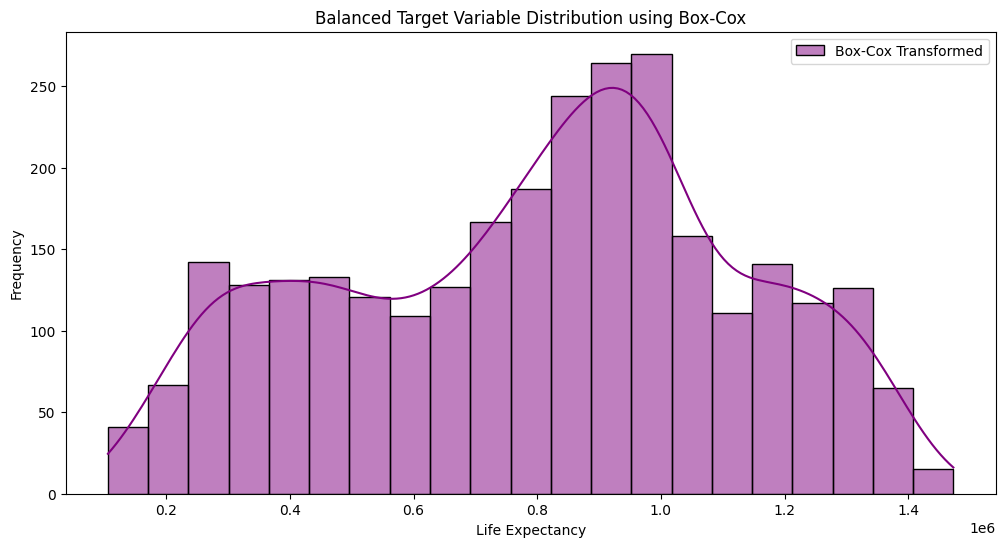

In [31]:
from sklearn.preprocessing import LabelEncoder
from scipy.stats import boxcox
import pandas as pd

# Load dataset
df = pd.read_csv('../data/data.csv')

# Label encoding for 'Country' due to high dimensionality
label_encoder = LabelEncoder()
df['Country'] = label_encoder.fit_transform(df['Country'])

# One-hot encoding for 'Region' due to low dimensionality
df_encoded = pd.get_dummies(df, columns=['Region'], drop_first=True)

# Separate features and target variable
X = df_encoded.drop(columns='Life_expectancy')
y = df_encoded['Life_expectancy']

# Apply Box-Cox transformation to the target (Life Expectancy)
# Box-Cox only accepts positive values, which are satisfied in life expectancy data
y_boxcox, lambda_val = boxcox(y)  # Store the lambda value for inverse transformation later if needed

# Updated feature matrix (X) and transformed target (y_boxcox)
X_transformed = X
y_transformed = pd.Series(y_boxcox, name="Life_expectancy_BoxCox")

# After balancing
plt.figure(figsize=(12, 6))
sns.histplot(y_transformed, kde=True, color='purple', label='Box-Cox Transformed')
plt.title("Balanced Target Variable Distribution using Box-Cox Transformation")
plt.xlabel("Life Expectancy")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [32]:
df = pd.read_csv('../data/data.csv')

# Use label encoding for Country because of high dimensionality (193 unique values)
label_encoder = LabelEncoder()
df['Country'] = label_encoder.fit_transform(df['Country'])

# Use one-hot encoding for Region because of low dimensionality (6 unique values)
df_encoded = pd.get_dummies(df, columns=['Region'], drop_first=True)

X = df_encoded.drop(columns='Life_expectancy')
y = df_encoded['Life_expectancy']

# Bin the 'Life_expectancy' column to create balanced data intervals for resampling
# Binning groups life expectancy values into intervals, here every 5 years, to facilitate balancing
df_encoded['Life_expectancy_bin'] = pd.cut(y, bins=np.arange(40, 90, 5))

balanced_data = pd.DataFrame()

# Loop over each bin category to resample and balance the dataset
# The goal is to ensure each life expectancy bin has an equal number of samples (here set to 100 per bin)
for life_bin in df_encoded['Life_expectancy_bin'].unique():
    bin_data = df_encoded[df_encoded['Life_expectancy_bin'] == life_bin]  # Filter data for the current bin
    if len(bin_data) > 0:
        # Resample with replacement to reach the desired number of samples (100) for this bin
        bin_sample = resample(bin_data, replace=True, n_samples=100, random_state=1) 
        # Concatenate the resampled data for each bin back into the balanced dataset
        balanced_data = pd.concat([balanced_data, bin_sample])

# After balancing, drop the temporary 'Life_expectancy_bin' column used for binning
balanced_data = balanced_data.drop(columns=['Life_expectancy_bin'])

X_balanced = balanced_data.drop(columns='Life_expectancy')
y_balanced = balanced_data['Life_expectancy']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=1)


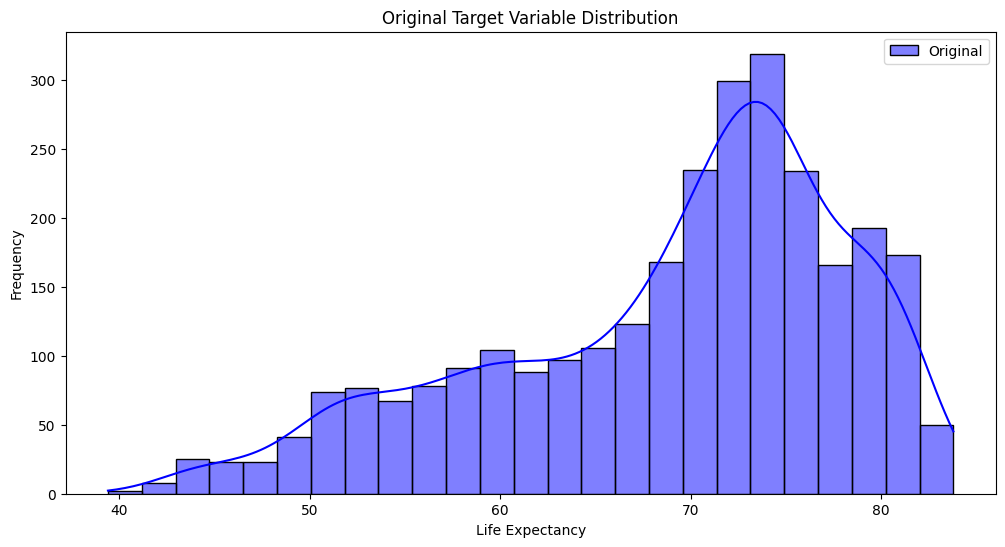

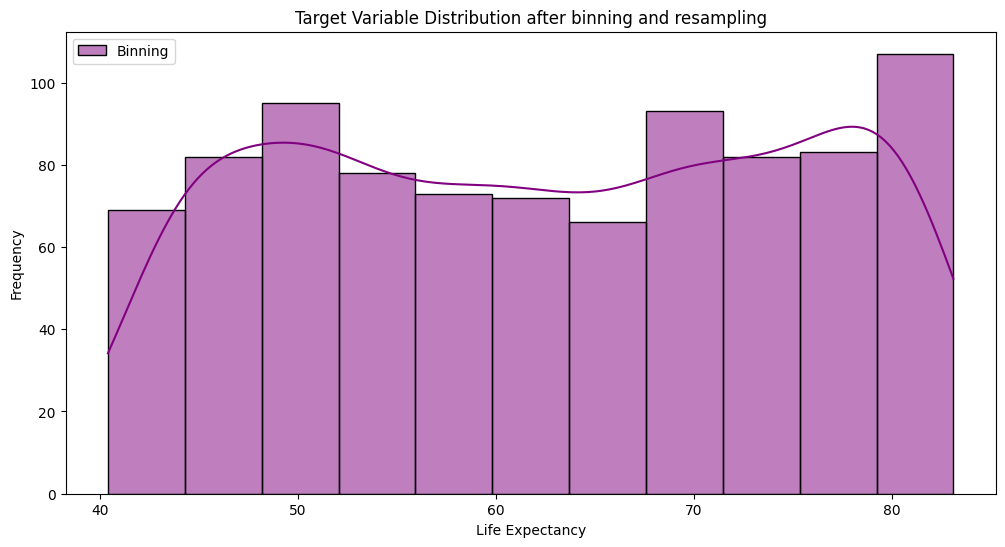

In [36]:
# Original target variable distribution
plt.figure(figsize=(12, 6))
sns.histplot(y, kde=True, color='blue', label='Original')
plt.title("Original Target Variable Distribution")
plt.xlabel("Life Expectancy")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# After balancing
plt.figure(figsize=(12, 6))
sns.histplot(y_balanced, kde=True, color='purple', label='Binning')
plt.title("Target Variable Distribution after binning and resampling")
plt.xlabel("Life Expectancy")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [34]:
# Handle imbalance using SMOGN, so that the regression models will not be overly influenced by overrepresented ranges of the target variable
# SMOGN is a method designed to balance continous target variables in regression problems
# It first divides the data into ranges based on spesific distance measures, then identifies the intervals that have fewer samples
# and generate synthetic samples for these intervals. It uses a combination of KNN and Gaussian noise to generate the synthetic samples.
# The method is based on the SMOTE algorithm, which is used for balancing classification problems.
data_for_smogn = X.copy()
data_for_smogn['Life_expectancy'] = y

data_smogn = smogn.smoter(data=data_for_smogn, y='Life_expectancy', k=5, samp_method='extreme', rel_thres=0.8)

# Fill missing values in the synthetic data
data_smogn = data_smogn.fillna(data_smogn.mean())

X_resampled = data_smogn.drop(columns=['Life_expectancy'])
y_resampled = data_smogn['Life_expectancy']

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

r_index: 100%|##########| 155/155 [00:00<00:00, 1563.68it/s]


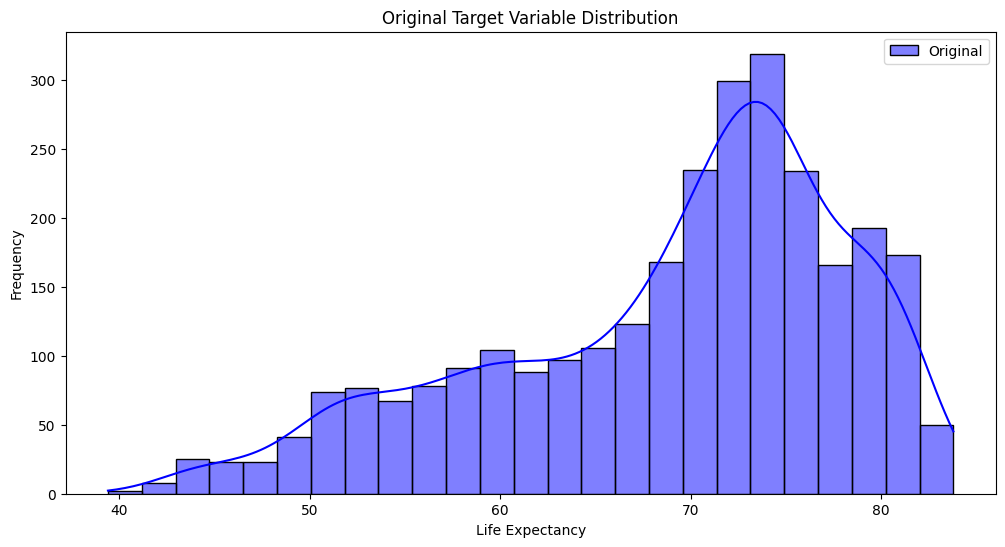

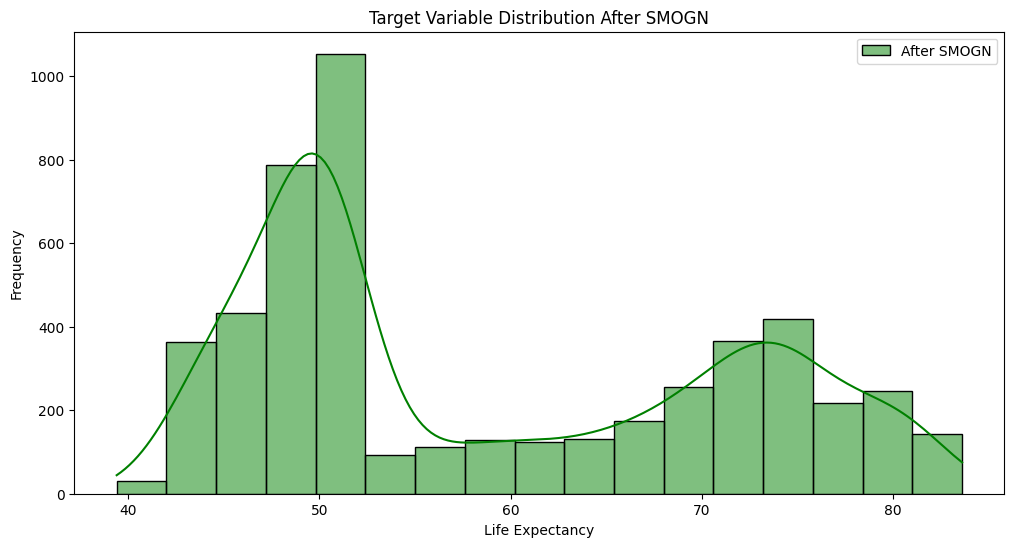

In [35]:
# Original target variable distribution
plt.figure(figsize=(12, 6))
sns.histplot(y, kde=True, color='blue', label='Original')
plt.title("Original Target Variable Distribution")
plt.xlabel("Life Expectancy")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# After applying SMOGN
plt.figure(figsize=(12, 6))
sns.histplot(y_resampled, kde=True, color='green', label='After SMOGN')
plt.title("Target Variable Distribution After SMOGN")
plt.xlabel("Life Expectancy")
plt.ylabel("Frequency")
plt.legend()
plt.show()